In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import interpolate
import pandas as pd
import sncosmo
import emcee
from multiprocessing import Pool
import corner
import glob
import quadpy
from scipy.optimize import minimize
from IPython.display import display, Math
import getdist
from getdist import plots, MCSamples

gk = quadpy.c1.gauss_kronrod(40)

### First round:
    
Values fixed at: $\alpha=0.1$, $\beta=2.5$ e $\sigma=0.15$
After MCMC with 200 walkers, 5000 steps, burn-in 1000: $\alpha=0.093 \pm 0.012$, $\beta=2.09 \pm 0.12$

Relative discrepancie: 7.5% and 19.6%

### Second round:
    
Values fixed at: $\alpha=0.093$, $\beta=2.09$ e $\sigma=0.15$
After MCMC with 200 walkers, 5000 steps, burn-in 1000: $\alpha=0.093 \pm 0.011$, $\beta= 2.07\pm 0.11$

Relative discrepancie: 0% and 0.1%

### Third round:
    
Values fixed at: $\alpha=0.093$, $\beta=2.07$ e $\sigma=0.15$
After MCMC with 200 walkers, 5000 steps, burn-in 1000: $\alpha=0.093 \pm 0.011$, $\beta= 2.07\pm 0.11$

Relative discrepancie: 0% and 0%

### Last round:
    
Values fixed at: $\alpha=0.093$, $\beta=2.07$ e $\sigma=0.132$

In [2]:
class cosmo:
    def __init__(self, data):
        self.data = data
        
    def dL(self,Ok, integral):
        if(Ok[0]>0.):
            return 1./np.sqrt(Ok[0])*np.sinh(np.sqrt(Ok[0])*np.array(integral))
        elif(Ok[0]==0.):
            return integral
        elif(Ok[0]<0.):
            return 1./np.sqrt(-Ok[0])*np.sin(np.sqrt(-Ok[0])*np.array(integral))
    
    def salt2_model_chi2(self,theta):
        Om, Ol, M, alpha, beta=theta
            
        alpha_fix=0.093
        beta_fix=2.07
        sig=0.132
            
        Ok=1.-Om-Ol
        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+Ol+(1.-Om-Ol)*(1+x)**2.)
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])
        
        model=5*np.log10((1+self.data["z"])*self.dL(np.array([Ok]*len(integral)),integral))+M
        mu=self.data["mB"]+self.data["x1"]*alpha-self.data["c"]*beta
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))
        
        cov=2.*alpha_fix*self.data["cov_mB_x1"]-2.*beta_fix*self.data["cov_mB_c"]-2.*alpha_fix*beta*self.data["cov_x1_c"]
        
        sigma2=sig**2+sigmaz**2.+self.data["mBerr"]**2+alpha_fix**2.*self.data["x1err"]**2+beta_fix**2.*self.data["cerr"]**2.+cov
        lnlike=-0.5*np.sum((mu-model)**2./sigma2)
        
        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike
    
    def log_prior(self, theta):
        Om, Ol, M, alpha, beta=theta     

        if not (0. < Om < 1. and -0.5 < Ol < 1.5 and 5. < M < 30. and 0. < alpha < 0.5 and 0. < beta < 3.5):
            return -np.inf
        return 0. 

    def log_probability_salt2_chi2(self,theta):
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.salt2_model_chi2(theta)

## Carregando dados

In [3]:
dat=pd.read_csv("SALT2.FITRES",sep="\s+")

In [4]:
cov_mB_x1=-2.5*np.log10(np.e)/dat["x0"]*dat["covx0x1"]
cov_mB_c=-2.5*np.log10(np.e)/dat["x0"]*dat["covx0c"]

In [5]:
data=dat[["Z","ZERR","mb","mberr","x1","x1err","c","cerr","covx1c"]]

In [6]:
data.insert(9, "cov_mB_x1",cov_mB_x1, True)
data.insert(10, "cov_mB_c",cov_mB_c, True)

In [7]:
data.columns=["z","zerr","mB","mBerr","x1","x1err","c","cerr","cov_x1_c","cov_mB_x1","cov_mB_c"]

In [8]:
cosmo_salt2=cosmo(data)

In [9]:
-2*cosmo_salt2.salt2_model_chi2([0.27,0.61,24.026,0.093,2.07])/288

0.9996822709715758

## Ajuste SALT2 $\chi^2$

In [10]:
cosmo_salt2.log_probability_salt2_chi2([0.3,0.7,24.,0.1,2.5])

-154.76621650769795

In [11]:
pos = np.array([0.3,0.7,24.,0.1,2.5])+0.01 *np.random.randn(200, 5)
nwalkers, ndim = pos.shape

In [12]:
with Pool() as pool:
    sampler_salt2_chi2 = emcee.EnsembleSampler(nwalkers, ndim, cosmo_salt2.log_probability_salt2_chi2, pool=pool)
    sampler_salt2_chi2.run_mcmc(pos, 5000, progress=True)

100%|███████████████████████████████████████| 5000/5000 [04:24<00:00, 18.93it/s]


#### Chains SALT2

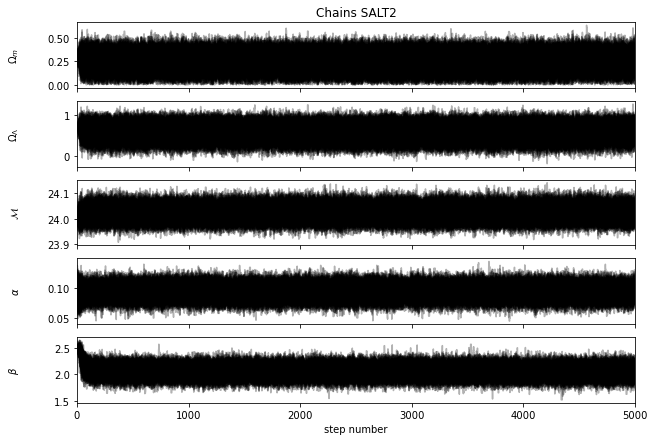

In [13]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_salt2_chi2 = sampler_salt2_chi2.get_chain()
labels = [r"$\Omega_m$",r"$\Omega_\Lambda$",r"$\mathcal{M}$",r"$\alpha$",r"$\beta$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_salt2_chi2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_salt2_chi2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    if i==0:
        ax.set_title("Chains SALT2")

    
axes[-1].set_xlabel("step number");

In [14]:
flat_samples_salt2_chi2 = sampler_salt2_chi2.get_chain(discard=1000, thin=15, flat=True)

In [15]:
labels_gdist = [r"\Omega_m",r"\Omega_\Lambda",r"\mathcal{M}",r"\alpha",r"\beta"]
names_gdist = ["Om","Ol","M","a","b"]
samples_salt2_chi2 = MCSamples(samples=flat_samples_salt2_chi2, names=names_gdist, labels=labels_gdist, label=r'$\chi^2, \sigma_{int}$=0.14')

Removed no burn in


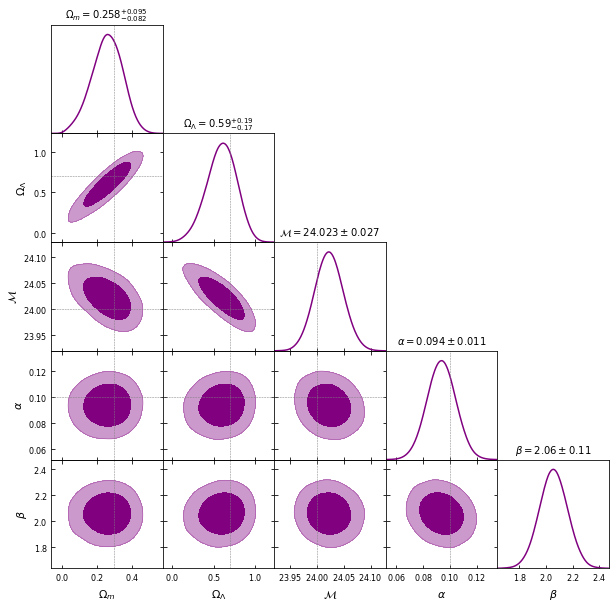

In [16]:
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 13
g.triangle_plot(samples_salt2_chi2, filled=True, title_limit=1, line_args=[{'lw':1.5, 'color':'purple'}], contour_colors=['purple'], markers={'Om':0.3,'Ol':0.7,'M':24.,'a':0.1,'b':2.5})

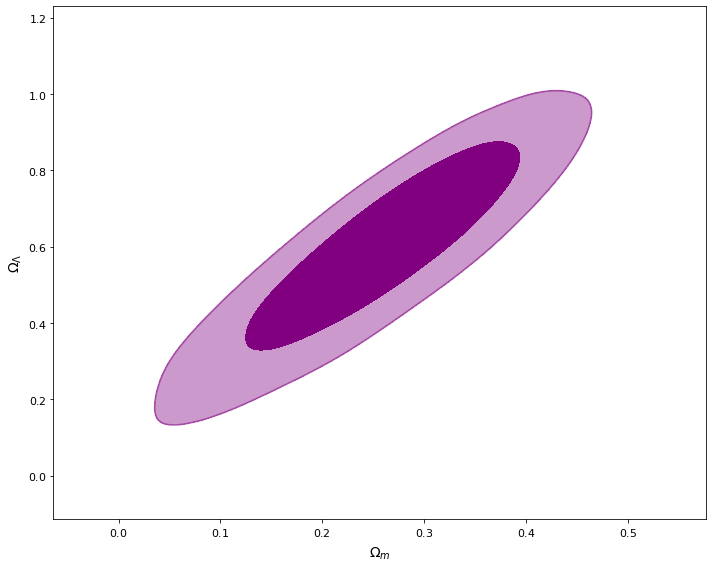

In [17]:
g = plots.get_single_plotter(width_inch=10, ratio=4 / 5.)
g.plot_2d([samples_salt2_chi2], 'Om', 'Ol', filled=True, colors=['purple']);

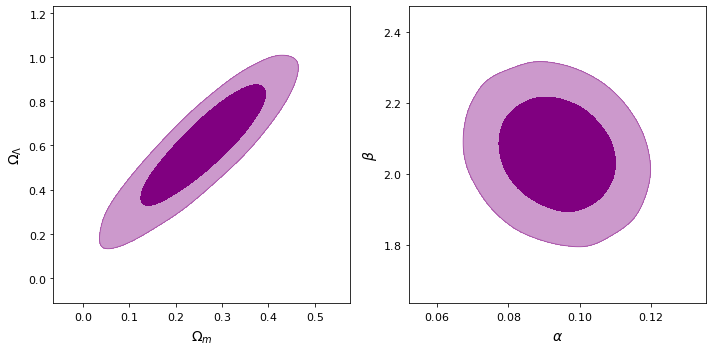

In [18]:
g = plots.get_subplot_plotter(width_inch=10)
g.plots_2d(samples_salt2_chi2, param_pairs=[['Om', 'Ol'], ['a', 'b']],nx=2, filled=True, colors=['purple']);